In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = 'cl-tohoku/bert-base-japanese-whole-word-masking'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
device = "cuda:0"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=8)

/home/sarashin/.local/share/virtualenvs/wrime-fd-hj1sF/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expecte

In [2]:
model_path = 'epoch_1.pth'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

array([1.6757526e-02, 3.8035531e-03, 9.7002721e-01, 1.9905847e-03,
       6.1475014e-04, 3.0087233e-03, 1.4069504e-03, 2.3906992e-03],
      dtype=float32)

<Figure size 500x100 with 0 Axes>

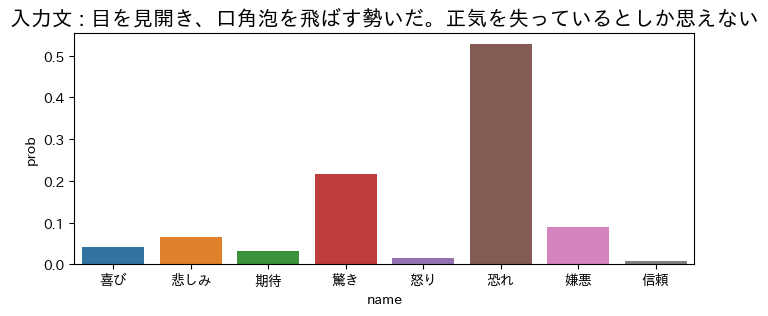

In [48]:
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import numpy as np
import pandas as pd

# 動作確認
plt.figure(figsize=(5,1))

emotion_names_jp = ['喜び', '悲しみ', '期待', '驚き', '怒り', '恐れ', '嫌悪', '信頼'] 

# ソフトマックス関数
# https://www.delftstack.com/ja/howto/numpy/numpy-softmax/
def np_softmax(x):
    f_x = np.exp(x) / np.sum(np.exp(x))
    return f_x

def analyze_emotion_show(text):
    # 推論モードを有効化
    model.eval()

    # 入力データ変換 + 推論
    tokens = tokenizer(text, truncation=True, return_tensors="pt")
    tokens.to(model.device)
    preds = model(**tokens)
    prob = np_softmax(preds.logits.cpu().detach().numpy()[0])
    out_dict = {n: p for n, p in zip(emotion_names_jp, prob)}

    # 棒グラフを描画
    plt.figure(figsize=(8, 3))
    df = pd.DataFrame(out_dict.items(), columns=['name', 'prob'])
    sns.barplot(x='name', y='prob', data=df)
    plt.title('入力文 : ' + text, fontsize=15)
    
def analyze_emotion(text):
    # 推論モードを有効化
    model.eval()

    # 入力データ変換 + 推論
    tokens = tokenizer(text, truncation=True, return_tensors="pt")
    tokens.to(model.device)
    preds = model(**tokens)
    prob = np_softmax(preds.logits.cpu().detach().numpy()[0])
    out_list = prob
    return out_list

analyze_emotion_show('目を見開き、口角泡を飛ばす勢いだ。正気を失っているとしか思えない')
analyze_emotion('明日のプレゼンうまくできるかなぁ…')

In [47]:
import glob

def get_story_num(story):
    return int(story.split('/')[-1].split('.')[0])

# 今度セリフだけ抜き出すやつも作る
def calc_emotion_story(ncode):
    path = './' + ncode + '/*.txt' 
    l = glob.glob(path)
    x = []
    for i, story in enumerate(l):
        print('chapter: ' + str(i+1))
        st_dict = {'chapter': get_story_num(story)}
        st_list = [0, 0, 0, 0, 0, 0, 0, 0]
        with open(story, 'r') as f:
            texts = f.readlines()
            for text in texts:
                analyzed_list = analyze_emotion(text)
                for j, e in enumerate(analyzed_list):
                    st_list[j] += e
                    
        soft = np_softmax(st_list)
        out_dict = {n: p for n, p in zip(emotion_names_jp, soft)}
        st_dict |= out_dict
        x.append(st_dict)

    df_tmp = pd.DataFrame(x)
    df_tmp.set_index('chapter', inplace=True)
    df = df_tmp.sort_index()
    return df

df_n3245fy = calc_emotion_story('n3245fy')
df_n3245fy.head()

chapter: 1


KeyboardInterrupt: 

                 喜び        悲しみ         期待         驚き        怒り         恐れ   
chapter                                                                     
1         39.278053  38.871351  32.139964  43.183865  2.577699  24.180705  \
2         44.134675  44.024836  46.207617  39.033589  4.000283  25.313712   
3         75.464266  63.779457  71.716957  72.147577  8.094365  38.668367   
4         35.820475  41.072591  36.562071  38.192481  3.946536  32.013927   
5         65.738292  61.689944  69.883584  58.950934  6.486271  41.006806   
...             ...        ...        ...        ...       ...        ...   
180       68.446409  53.386126  50.095722  45.490486  5.744806  31.578631   
181       26.000061  29.062154  26.037003  30.439500  3.231125  20.813684   
182       69.180254  52.023433  47.411014  52.469037  3.879308  27.314293   
183      102.559068  68.833559  69.736899  71.272605  5.694999  42.604080   
184       45.881714  37.372302  44.131010  35.652433  3.621743  23.903369   

array([<Axes: xlabel='chapter'>, <Axes: xlabel='chapter'>,
       <Axes: xlabel='chapter'>, <Axes: xlabel='chapter'>,
       <Axes: xlabel='chapter'>, <Axes: xlabel='chapter'>,
       <Axes: xlabel='chapter'>, <Axes: xlabel='chapter'>], dtype=object)

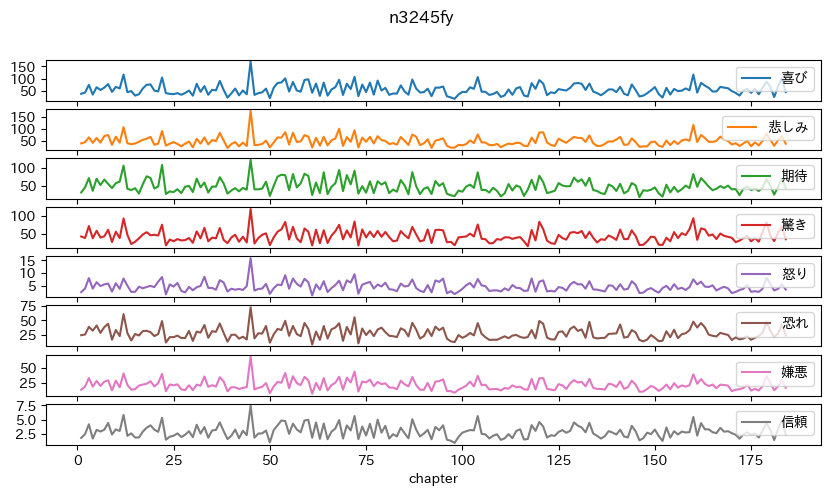

In [44]:
pd.options.display.precision = 6
print(df_n3245fy)
df_n3245fy.plot.line(figsize=(10, 5), title='n3245fy', subplots=True)

In [49]:
df_n4744ia = calc_emotion_story('n4744ia')
df_n4744ia.head()

chapter: 1
chapter: 2
chapter: 3
chapter: 4
chapter: 5
chapter: 6
chapter: 7
chapter: 8
chapter: 9
chapter: 10
chapter: 11
chapter: 12
chapter: 13
chapter: 14
chapter: 15
chapter: 16
chapter: 17
chapter: 18
chapter: 19
chapter: 20
chapter: 21
chapter: 22
chapter: 23
chapter: 24
chapter: 25
chapter: 26
chapter: 27
chapter: 28
chapter: 29
chapter: 30
chapter: 31
chapter: 32
chapter: 33
chapter: 34
chapter: 35
chapter: 36
chapter: 37
chapter: 38
chapter: 39
chapter: 40
chapter: 41
chapter: 42
chapter: 43
chapter: 44
chapter: 45
chapter: 46
chapter: 47
chapter: 48
chapter: 49
chapter: 50
chapter: 51
chapter: 52
chapter: 53
chapter: 54
chapter: 55
chapter: 56
chapter: 57
chapter: 58
chapter: 59
chapter: 60
chapter: 61
chapter: 62
chapter: 63
chapter: 64
chapter: 65
chapter: 66
chapter: 67
chapter: 68
chapter: 69
chapter: 70
chapter: 71
chapter: 72
chapter: 73
chapter: 74
chapter: 75
chapter: 76
chapter: 77
chapter: 78
chapter: 79
chapter: 80
chapter: 81
chapter: 82
chapter: 83
chapter: 84
c

,喜び,悲しみ,期待,驚き,怒り,恐れ,嫌悪,信頼
chapter,,,,,,,,
1,0.971089,1.372379e-05,2.889037e-02,0.000007,2.211787e-22,1.034649e-12,6.439808e-16,8.760020e-23
2,0.088189,6.595276e-01,2.775368e-03,0.249371,4.204391e-08,1.327400e-04,4.240732e-06,2.911194e-08
3,0.529246,4.359225e-01,1.150914e-02,0.023311,8.035058e-09,6.648998e-06,4.786481e-06,4.495926e-09
4,0.978704,9.768577e-03,1.118469e-03,0.010403,7.547132e-10,4.453890e-06,1.265145e-06,3.237824e-10
5,0.999931,5.810702e-10,1.369529e-09,0.000069,1.487589e-19,8.965285e-15,5.501053e-16,1.336307e-19


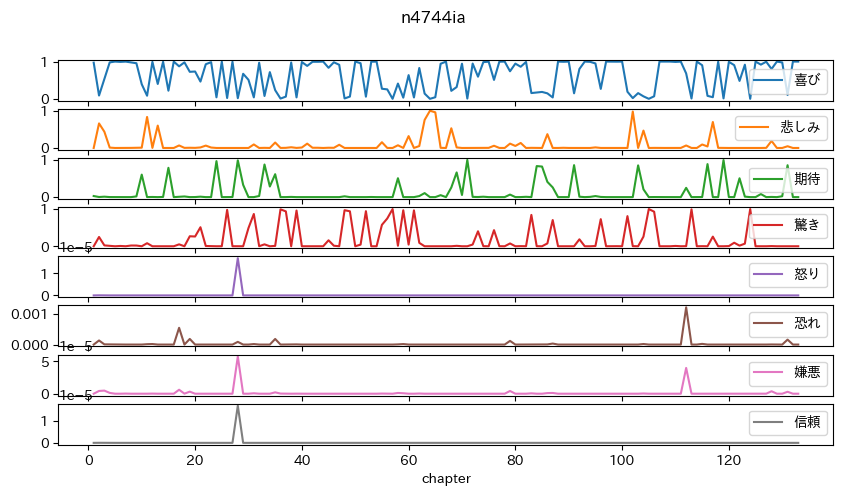

In [51]:
df_n4744ia.plot.line(figsize=(10, 5), title='n4744ia', subplots=True)
# df_n4744ia.to_csv('n4744ia.csv')

array([<Axes: xlabel='chapter'>, <Axes: xlabel='chapter'>,
       <Axes: xlabel='chapter'>, <Axes: xlabel='chapter'>,
       <Axes: xlabel='chapter'>, <Axes: xlabel='chapter'>,
       <Axes: xlabel='chapter'>, <Axes: xlabel='chapter'>], dtype=object)

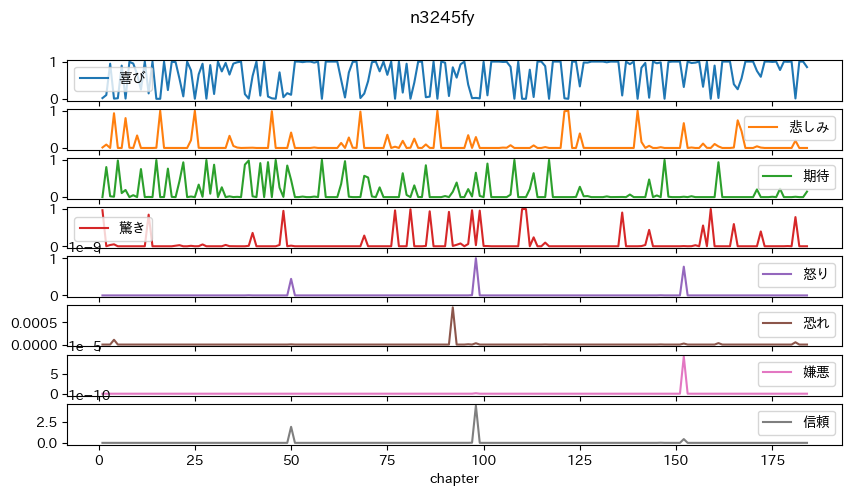

In [54]:
df_n3245fy = pd.read_csv('n3245fy.csv')
df_n3245fy.set_index('chapter', inplace=True)
df_n3245fy.plot.line(figsize=(10, 5), title='n3245fy', subplots=True)

In [67]:
# セリフだけ抜き出すやつ
def calc_emotion_story_quote(ncode):
    path = './' + ncode + '/*.txt' 
    l = glob.glob(path)
    x = []
    for i, story in enumerate(l):
        print('chapter: ' + str(i+1))
        st_dict = {'chapter': get_story_num(story)}
        st_list = [0, 0, 0, 0, 0, 0, 0, 0]
        with open(story, 'r') as f:
            texts = f.readlines()
            for text in texts:
                if text.startswith('「') or text.startswith('『') or text.startswith('(') or text.startswith('―') or text.startswith('.'):
                    text = text.replace('「', '')
                    text = text.replace('」', '')
                    text = text.replace('『', '')
                    text = text.replace('』', '')
                    text = text.replace('（', '')
                    text = text.replace('）', '')
                    analyzed_list = analyze_emotion(text)
                    for j, e in enumerate(analyzed_list):
                        st_list[j] += e
                    
        soft = np_softmax(st_list)
        out_dict = {n: p for n, p in zip(emotion_names_jp, soft)}
        st_dict |= out_dict
        x.append(st_dict)

    df_tmp = pd.DataFrame(x)
    df_tmp.set_index('chapter', inplace=True)
    df = df_tmp.sort_index()
    return df

In [56]:
df_n4744ia_quote = calc_emotion_story_quote('n4744ia')
df_n3245fy_quote = calc_emotion_story_quote('n3245fy')

chapter: 1
chapter: 2
chapter: 3
chapter: 4
chapter: 5
chapter: 6
chapter: 7
chapter: 8
chapter: 9
chapter: 10
chapter: 11
chapter: 12
chapter: 13
chapter: 14
chapter: 15
chapter: 16
chapter: 17
chapter: 18
chapter: 19
chapter: 20
chapter: 21
chapter: 22
chapter: 23
chapter: 24
chapter: 25
chapter: 26
chapter: 27
chapter: 28
chapter: 29
chapter: 30
chapter: 31
chapter: 32
chapter: 33
chapter: 34
chapter: 35
chapter: 36
chapter: 37
chapter: 38
chapter: 39
chapter: 40
chapter: 41
chapter: 42
chapter: 43
chapter: 44
chapter: 45
chapter: 46
chapter: 47
chapter: 48
chapter: 49
chapter: 50
chapter: 51
chapter: 52
chapter: 53
chapter: 54
chapter: 55
chapter: 56
chapter: 57
chapter: 58
chapter: 59
chapter: 60
chapter: 61
chapter: 62
chapter: 63
chapter: 64
chapter: 65
chapter: 66
chapter: 67
chapter: 68
chapter: 69
chapter: 70
chapter: 71
chapter: 72
chapter: 73
chapter: 74
chapter: 75
chapter: 76
chapter: 77
chapter: 78
chapter: 79
chapter: 80
chapter: 81
chapter: 82
chapter: 83
chapter: 84
c

In [57]:
df_n3245fy_quote.to_csv('n3245fy_quote.csv')
df_n4744ia_quote.to_csv('n4744ia_quote.csv')

array([<Axes: xlabel='chapter'>, <Axes: xlabel='chapter'>,
       <Axes: xlabel='chapter'>, <Axes: xlabel='chapter'>,
       <Axes: xlabel='chapter'>, <Axes: xlabel='chapter'>,
       <Axes: xlabel='chapter'>, <Axes: xlabel='chapter'>], dtype=object)

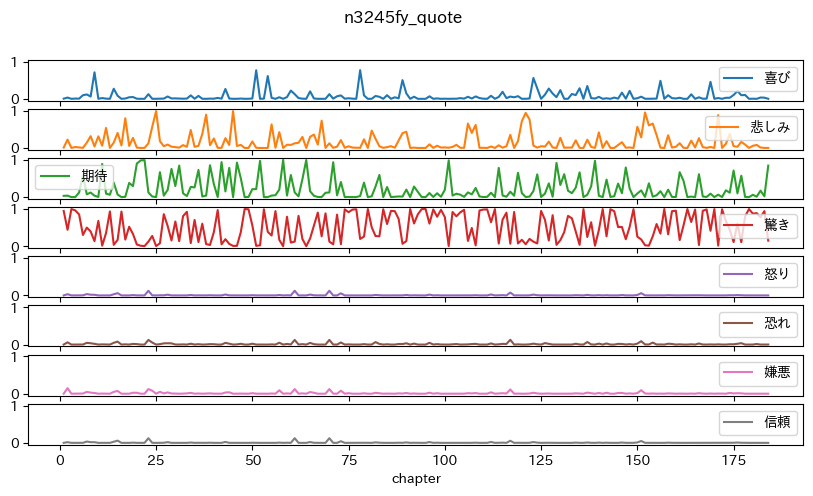

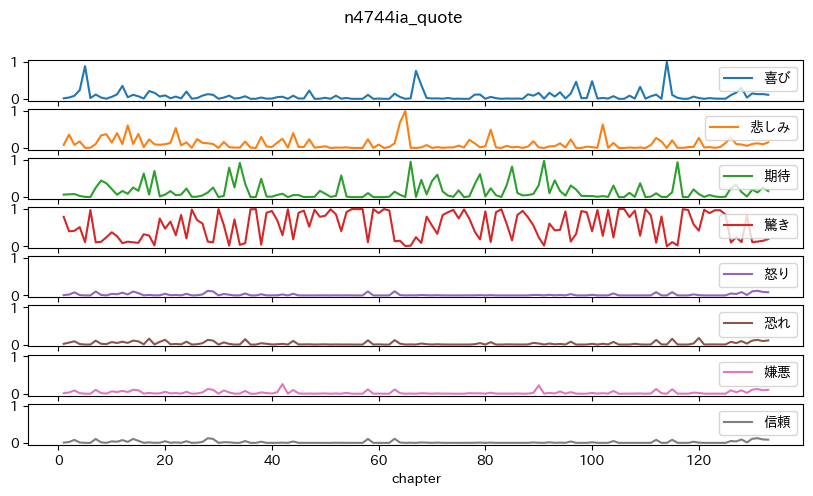

In [59]:
df_n3245fy_quote.plot.line(figsize=(10, 5), title='n3245fy_quote', subplots=True, sharey=True)
df_n4744ia_quote.plot.line(figsize=(10, 5), title='n4744ia_quote', subplots=True, sharey=True)

In [68]:
def calc_emotion_line_quote(ncode):
    path = './' + ncode + '/*.txt' 
    l = glob.glob(path)
    x = []
    for i, story in enumerate(l):
        print('chapter: ' + str(i+1))
        with open(story, 'r') as f:
            texts = f.readlines()
            for k, text in enumerate(texts):
                line_dict = {'chapter': get_story_num(story), 'line': k+1}
                if text.startswith('「') or text.startswith('『') or text.startswith('(') or text.startswith('―') or text.startswith('.'):
                    text = text.replace('「', '')
                    text = text.replace('」', '')
                    text = text.replace('『', '')
                    text = text.replace('』', '')
                    text = text.replace('（', '')
                    text = text.replace('）', '')
                    analyzed_list = analyze_emotion(text)
                    out_dict = {n: p for n, p in zip(emotion_names_jp, analyzed_list)}
                    line_dict |= out_dict
                    x.append(line_dict)

    df_tmp = pd.DataFrame(x)
    df = df_tmp.sort_values(['chapter', 'line'])
    return df

In [69]:
df_n4744ia_line = calc_emotion_line_quote('n4744ia')
df_n3245fy_line = calc_emotion_line_quote('n3245fy')

chapter: 1
chapter: 2
chapter: 3
chapter: 4
chapter: 5
chapter: 6
chapter: 7
chapter: 8
chapter: 9
chapter: 10
chapter: 11
chapter: 12
chapter: 13
chapter: 14
chapter: 15
chapter: 16
chapter: 17
chapter: 18
chapter: 19
chapter: 20
chapter: 21
chapter: 22
chapter: 23
chapter: 24
chapter: 25
chapter: 26
chapter: 27
chapter: 28
chapter: 29
chapter: 30
chapter: 31
chapter: 32
chapter: 33
chapter: 34
chapter: 35
chapter: 36
chapter: 37
chapter: 38
chapter: 39
chapter: 40
chapter: 41
chapter: 42
chapter: 43
chapter: 44
chapter: 45
chapter: 46
chapter: 47
chapter: 48
chapter: 49
chapter: 50
chapter: 51
chapter: 52
chapter: 53
chapter: 54
chapter: 55
chapter: 56
chapter: 57
chapter: 58
chapter: 59
chapter: 60
chapter: 61
chapter: 62
chapter: 63
chapter: 64
chapter: 65
chapter: 66
chapter: 67
chapter: 68
chapter: 69
chapter: 70
chapter: 71
chapter: 72
chapter: 73
chapter: 74
chapter: 75
chapter: 76
chapter: 77
chapter: 78
chapter: 79
chapter: 80
chapter: 81
chapter: 82
chapter: 83
chapter: 84
c

In [70]:
df_n3245fy_line.set_index(['chapter', 'line'], inplace=True)
df_n4744ia_line.set_index(['chapter', 'line'], inplace=True)

df_n3245fy_line.to_csv('n3245fy_line.csv')
df_n4744ia_line.to_csv('n4744ia_line.csv')

array([<Axes: xlabel='chapter,line'>, <Axes: xlabel='chapter,line'>,
       <Axes: xlabel='chapter,line'>, <Axes: xlabel='chapter,line'>,
       <Axes: xlabel='chapter,line'>, <Axes: xlabel='chapter,line'>,
       <Axes: xlabel='chapter,line'>, <Axes: xlabel='chapter,line'>],
      dtype=object)

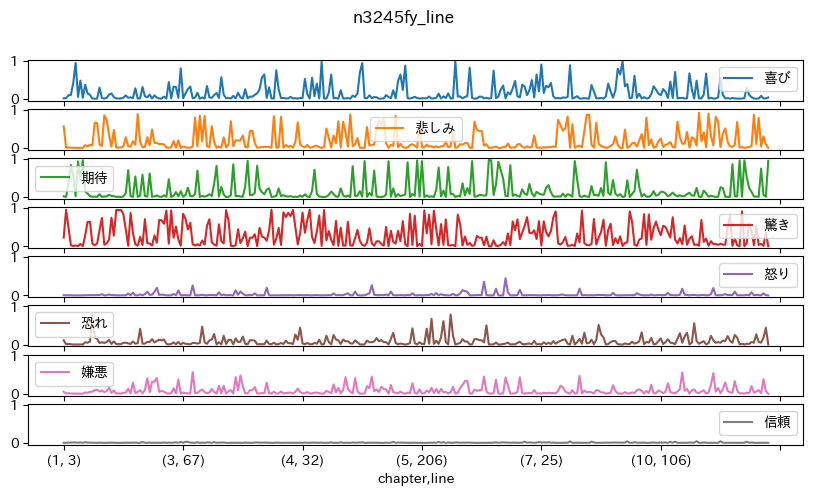

In [73]:
df_n3245fy_line_joban = df_n3245fy_line.loc[1:10]
df_n3245fy_line_joban.plot.line(figsize=(10, 5), title='n3245fy_line', subplots=True, sharey=True)

array([<Axes: xlabel='chapter,line'>, <Axes: xlabel='chapter,line'>,
       <Axes: xlabel='chapter,line'>, <Axes: xlabel='chapter,line'>,
       <Axes: xlabel='chapter,line'>, <Axes: xlabel='chapter,line'>,
       <Axes: xlabel='chapter,line'>, <Axes: xlabel='chapter,line'>],
      dtype=object)

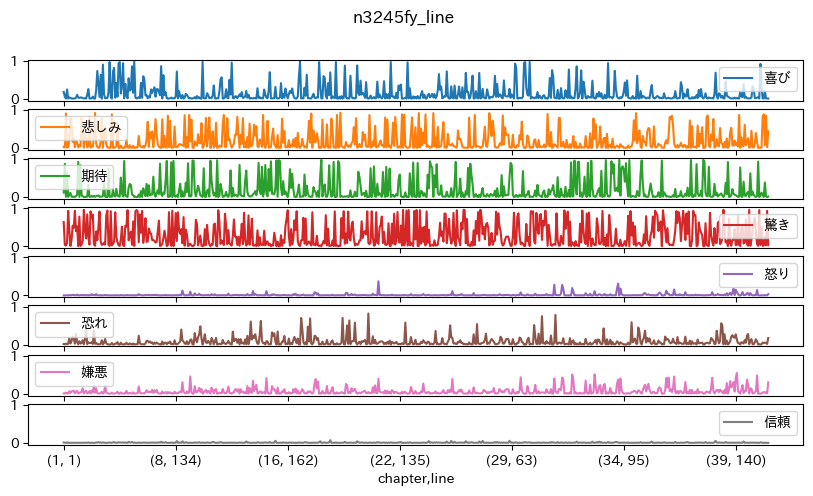

In [74]:
df_n4744ia_line_joban = df_n4744ia_line.loc[1:40]
df_n4744ia_line_joban.plot.line(figsize=(10, 5), title='n3245fy_line', subplots=True, sharey=True)

In [75]:
df_n9078bd_line = calc_emotion_line_quote('n9078bd')

chapter: 1
chapter: 2
chapter: 3
chapter: 4
chapter: 5
chapter: 6
chapter: 7
chapter: 8
chapter: 9
chapter: 10
chapter: 11
chapter: 12
chapter: 13
chapter: 14
chapter: 15
chapter: 16
chapter: 17
chapter: 18
chapter: 19
chapter: 20
chapter: 21
chapter: 22
chapter: 23
chapter: 24
chapter: 25
chapter: 26
chapter: 27
chapter: 28
chapter: 29
chapter: 30
chapter: 31
chapter: 32
chapter: 33
chapter: 34
chapter: 35
chapter: 36
chapter: 37
chapter: 38
chapter: 39
chapter: 40
chapter: 41
chapter: 42
chapter: 43
chapter: 44
chapter: 45
chapter: 46
chapter: 47
chapter: 48
chapter: 49
chapter: 50
chapter: 51
chapter: 52
chapter: 53
chapter: 54
chapter: 55
chapter: 56
chapter: 57
chapter: 58
chapter: 59
chapter: 60
chapter: 61
chapter: 62
chapter: 63
chapter: 64
chapter: 65
chapter: 66
chapter: 67
chapter: 68
chapter: 69
chapter: 70
chapter: 71
chapter: 72
chapter: 73
chapter: 74
chapter: 75
chapter: 76
chapter: 77
chapter: 78
chapter: 79
chapter: 80
chapter: 81
chapter: 82
chapter: 83
chapter: 84
c

In [77]:
df_n9078bd_line.set_index(['chapter', 'line'], inplace=True)
df_n9078bd_line.to_csv('n9078bd_line.csv')
df_n9078bd_line.head()

喜び       悲しみ        期待        驚き        怒り        恐れ   
chapter line                                                               
1       3     0.009787  0.212480  0.011991  0.147266  0.057983  0.239970  \
        26    0.006068  0.295687  0.010141  0.092489  0.064981  0.286071   
        37    0.005119  0.801210  0.006107  0.014270  0.006395  0.051597   
        45    0.016493  0.041476  0.007431  0.774767  0.012311  0.093287   
        46    0.014040  0.066365  0.014243  0.371100  0.013591  0.433025   

                    嫌悪        信頼  
chapter line                      
1       3     0.318229  0.002294  
        26    0.241330  0.003233  
        37    0.114162  0.001139  
        45    0.052190  0.002045  
        46    0.085085  0.002552

array([<Axes: xlabel='chapter,line'>, <Axes: xlabel='chapter,line'>,
       <Axes: xlabel='chapter,line'>, <Axes: xlabel='chapter,line'>,
       <Axes: xlabel='chapter,line'>, <Axes: xlabel='chapter,line'>,
       <Axes: xlabel='chapter,line'>, <Axes: xlabel='chapter,line'>],
      dtype=object)

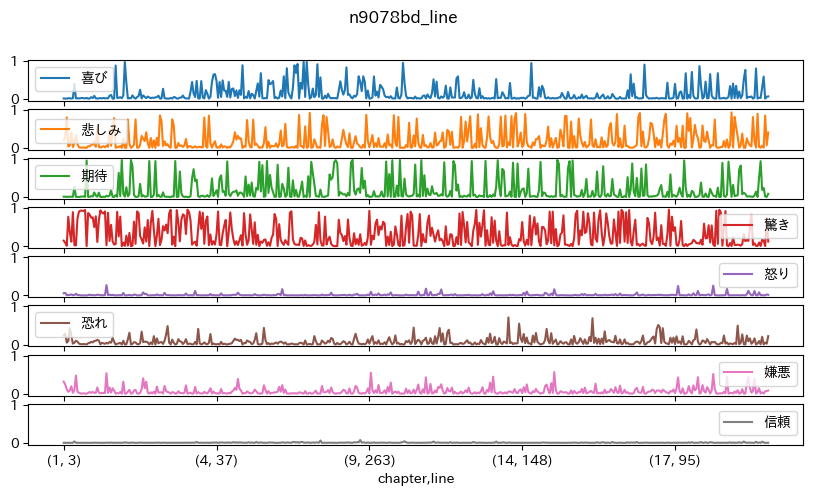

In [78]:
df_n9078bd_line_joban = df_n9078bd_line.loc[1:18]
df_n9078bd_line_joban.plot.line(figsize=(10, 5), title='n9078bd_line', subplots=True, sharey=True)

In [79]:
df_n9078bd = calc_emotion_story('n9078bd')

chapter: 1
chapter: 2
chapter: 3
chapter: 4
chapter: 5
chapter: 6
chapter: 7
chapter: 8
chapter: 9
chapter: 10
chapter: 11
chapter: 12
chapter: 13
chapter: 14
chapter: 15
chapter: 16
chapter: 17
chapter: 18
chapter: 19
chapter: 20
chapter: 21
chapter: 22
chapter: 23
chapter: 24
chapter: 25
chapter: 26
chapter: 27
chapter: 28
chapter: 29
chapter: 30
chapter: 31
chapter: 32
chapter: 33
chapter: 34
chapter: 35
chapter: 36
chapter: 37
chapter: 38
chapter: 39
chapter: 40
chapter: 41
chapter: 42
chapter: 43
chapter: 44
chapter: 45
chapter: 46
chapter: 47
chapter: 48
chapter: 49
chapter: 50
chapter: 51
chapter: 52
chapter: 53
chapter: 54
chapter: 55
chapter: 56
chapter: 57
chapter: 58
chapter: 59
chapter: 60
chapter: 61
chapter: 62
chapter: 63
chapter: 64
chapter: 65
chapter: 66
chapter: 67
chapter: 68
chapter: 69
chapter: 70
chapter: 71
chapter: 72
chapter: 73
chapter: 74
chapter: 75
chapter: 76
chapter: 77
chapter: 78
chapter: 79
chapter: 80
chapter: 81
chapter: 82
chapter: 83
chapter: 84
c

In [80]:
df_n9078bd.to_csv('n9078bd.csv')

array([<Axes: xlabel='chapter'>, <Axes: xlabel='chapter'>,
       <Axes: xlabel='chapter'>, <Axes: xlabel='chapter'>,
       <Axes: xlabel='chapter'>, <Axes: xlabel='chapter'>,
       <Axes: xlabel='chapter'>, <Axes: xlabel='chapter'>], dtype=object)

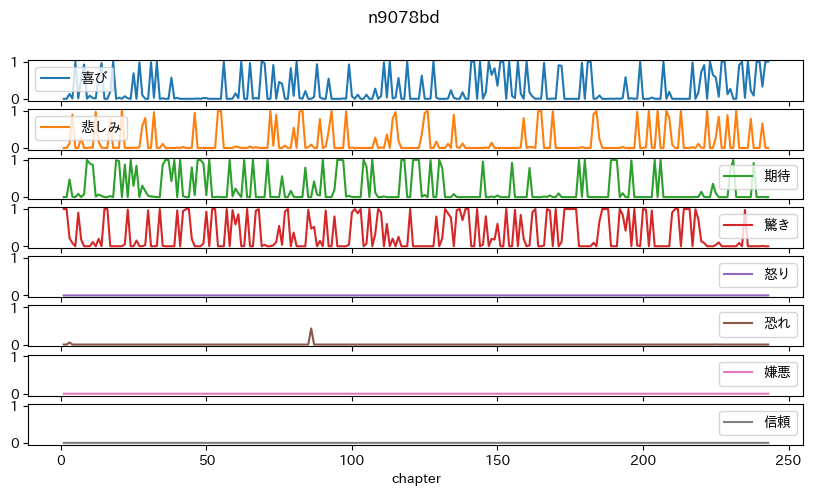

In [81]:
df_n9078bd.plot.line(figsize=(10, 5), title='n9078bd', subplots=True, sharey=True)

In [85]:
def calc_emotion_line(ncode, left:int, right:int):
    path = './' + ncode + '/*.txt' 
    l_tmp = glob.glob(path)
    l = sorted(l_tmp, key=lambda x: get_story_num(x))
    x = []
    for i, story in enumerate(l):
        if i+1 < left:
            continue
        if i+1 > right:
            break
        print('chapter: ' + str(i+1))
        with open(story, 'r') as f:
            texts = f.readlines()
            for k, text in enumerate(texts):
                line_dict = {'chapter': get_story_num(story), 'line': k+1}
                analyzed_list = analyze_emotion(text)
                out_dict = {n: p for n, p in zip(emotion_names_jp, analyzed_list)}
                line_dict |= out_dict
                x.append(line_dict)

    df_tmp = pd.DataFrame(x)
    df = df_tmp.sort_values(['chapter', 'line'])
    df.set_index(['chapter', 'line'], inplace=True)
    return df


In [86]:
df_n9078bd_all_line = calc_emotion_line('n9078bd', 1, 20)
df_n3245fy_all_line = calc_emotion_line('n3245fy', 1, 20)
df_n4744ia_all_line = calc_emotion_line('n4744ia', 1, 20)

chapter: 1
chapter: 2
chapter: 3
chapter: 4
chapter: 5
chapter: 6
chapter: 7
chapter: 8
chapter: 9
chapter: 10
chapter: 11
chapter: 12
chapter: 13
chapter: 14
chapter: 15
chapter: 16
chapter: 17
chapter: 18
chapter: 19
chapter: 20
chapter: 1
chapter: 2
chapter: 3
chapter: 4
chapter: 5
chapter: 6
chapter: 7
chapter: 8
chapter: 9
chapter: 10
chapter: 11
chapter: 12
chapter: 13
chapter: 14
chapter: 15
chapter: 16
chapter: 17
chapter: 18
chapter: 19
chapter: 20
chapter: 1
chapter: 2
chapter: 3
chapter: 4
chapter: 5
chapter: 6
chapter: 7
chapter: 8
chapter: 9
chapter: 10
chapter: 11
chapter: 12
chapter: 13
chapter: 14
chapter: 15
chapter: 16
chapter: 17
chapter: 18
chapter: 19
chapter: 20


In [94]:
df_n3245fy_all_line.to_csv('n3245fy_all_line.csv')
df_n4744ia_all_line.to_csv('n4744ia_all_line.csv')
df_n9078bd_all_line.to_csv('n9078bd_all_line.csv')

array([<Axes: xlabel='chapter,line'>, <Axes: xlabel='chapter,line'>,
       <Axes: xlabel='chapter,line'>, <Axes: xlabel='chapter,line'>,
       <Axes: xlabel='chapter,line'>, <Axes: xlabel='chapter,line'>,
       <Axes: xlabel='chapter,line'>, <Axes: xlabel='chapter,line'>],
      dtype=object)

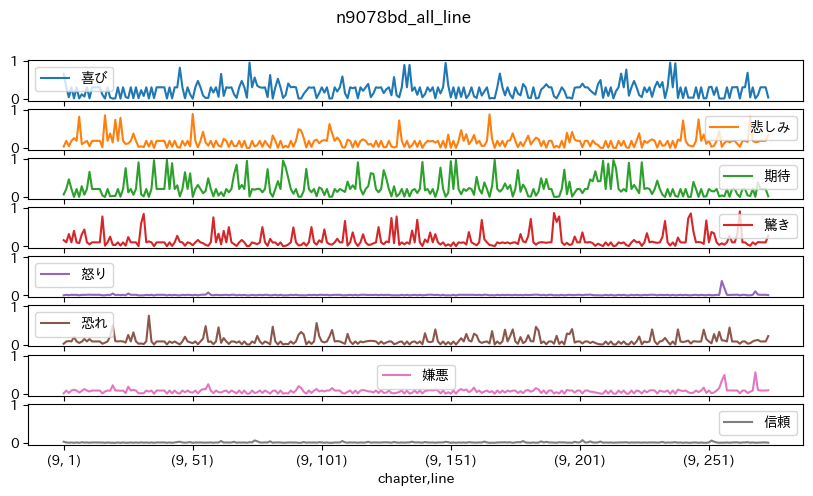

In [101]:
df_n9078bd_all_line_joban = df_n9078bd_all_line.loc[9:9]
df_n9078bd_all_line_joban.plot.line(figsize=(10, 5), title='n9078bd_all_line', subplots=True, sharey=True)